In [1]:
pip install numpy==1.24.4 gensim==4.3.0

     |████████████████████████████████| 19.8 MB 498 kB/s eta 0:00:01
     |████████████████████████████████| 24.0 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 61 kB 262 kB/s eta 0:00:01
     |████████████████████████████████| 60 kB 6.8 MB/s  eta 0:00:01
     |████████████████████████████████| 35.2 MB 132 kB/s eta 0:00:01
     |████████████████████████████████| 12.0 MB 1.0 MB/s eta 0:00:01
  Using cached fst_pso-1.8.1-py3-none-any.whl
  Using cached miniful-0.0.6-py3-none-any.whl
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.0
    Uninstalling numpy-1.26.0:
      Successfully uninstalled numpy-1.26.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.3
    Uninstalling pandas-2.2.3:
      Successfully uninstalled pandas-2.2.3
Note: you may need to restart the kernel to

# Классификация эмоциональной окраски узбекских текстов (0–5)
# 1. Загрузка данных

In [2]:
import pandas as pd

# Загрузка обучающего и валидационного датасетов
train_df = pd.read_csv("data/raw/train.csv")
val_df = pd.read_csv("data/raw/validation.csv")

# Разделяем тексты и метки классов
X_train_texts = train_df['uzbek_text'].astype(str)   # узбекские тексты обучающей выборки
y_train = train_df['label'].values                  # метки (0–5) для обучающей выборки
X_val_texts = val_df['uzbek_text'].astype(str)       # узбекские тексты валидационной выборки
y_val = val_df['label'].values                      # истинные метки для валидационной выборки

# Проверяем размеры наборов данных
print(f"Обучающая выборка: {len(X_train_texts)} примеров, Валидационная выборка: {len(X_val_texts)} примеров")
print("Пример обучающего текста:", X_train_texts.iloc[0])
print("Его метка класса:", y_train[0])


Обучающая выборка: 16000 примеров, Валидационная выборка: 2000 примеров
Пример обучающего текста: Men o'zimni kamsitilgan his qilmadim
Его метка класса: 0


# 2. Загрузка списка стоп-слов

In [3]:
# Загрузка стоп-слов из файла
def load_stopwords(file_path):
    stopwords = set()
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            if not line:
                continue
            # Пробуем сначала разделить по табуляции
            if '\t' in line:
                parts = line.split('\t')
                word = parts[-1].strip()
            else:
                # Альтернативно: удаляем номер перед словом (если есть точка)
                word = line.split('.', 1)[-1].strip()
            if word:
                stopwords.add(word)
    return stopwords

# Пример использования
uz_stopwords = load_stopwords('data/uzbek_stopwords/stopwords_unigrams.txt')

print(f"Загружено {len(uz_stopwords)} узбекских стоп-слов.")
# Выведем несколько для примера
print("Примеры стоп-слов:", list(uz_stopwords)[:10])


Загружено 5270 узбекских стоп-слов.
Примеры стоп-слов: ["g'idi-bidi", 'fotih', "to'plamga", 'xokisorona', 'avqot', 'boshlanmasi', "to'lg'amo", 'chirmamoq', 'sallali', 'dardisar']


# 3. Предобработка текста.
#### Предобработка выполняет стандартные шаги: тексты приводятся к нижнему регистру, ненужные символы (цифры, знаки препинания, эмодзи и пр.) удаляются, текст разбивается на слова (токены), из которых затем исключаются распространённые узбекские стоп-слова. В результате остаются значимые слова, которые будут использоваться в качестве признаков.

In [4]:
import re

# Функция предобработки для одного текста
def preprocess_text(text):
    # 1. Приведение текста к нижнему регистру
    text = text.lower()
    # 2. Замена вариантов апострофа на единый символ (например, U+2018, U+2019, U+02BB -> ')
    text = text.replace("\u2018", "'").replace("\u2019", "'").replace("\u02bb", "'").replace("\u02bc", "'")
    # 3. Удаление лишних символов: оставляем только буквы, пробелы и апострофы, остальные символы заменяем на пробел
    cleaned_chars = []
    for ch in text:
        if ch.isalpha() or ch == "'" or ch.isspace():
            cleaned_chars.append(ch)
        else:
            cleaned_chars.append(" ")
    text = "".join(cleaned_chars)
    # 4. Токенизация: разделяем текст по пробелам на слова
    tokens = text.split()
    # 5. Удаление стоп-слов и очень коротких токенов
    tokens = [tok for tok in tokens if tok not in uz_stopwords and len(tok) > 0]
    return tokens

# Пример предобработки на одном предложении
sample_text = "Men juda qayg'uli va o'zim uchun afsusdaman, lekin 😢"
print("Исходный текст:", sample_text)
print("После предобработки:", preprocess_text(sample_text))


Исходный текст: Men juda qayg'uli va o'zim uchun afsusdaman, lekin 😢
После предобработки: ["qayg'uli", "o'zim", 'afsusdaman', 'lekin']


# 4. Создание признакового представления (Bag of Words, TF-IDF, Word2Vec)
#### Мы получили две разреженные матрицы признаков: Bag-of-Words (частотное представление слов) и TF-IDF (взвешенное представление). Каждая строка матрицы соответствует тексту, а каждый столбец – определённому слову из словаря. min_df=2 означает, что слова, встречающиеся только один раз, отброшены, чтобы уменьшить шум.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Создаем CountVectorizer для Bag-of-Words и TfidfVectorizer для TF-IDF.
# Используем нашу функцию preprocess_text как анализатор, чтобы применять ту же токенизацию и очистку.
count_vectorizer = CountVectorizer(analyzer=preprocess_text, min_df=2)
tfidf_vectorizer = TfidfVectorizer(analyzer=preprocess_text, min_df=2)

# Обучаем словарь (vocabulary) на обучающих данных и сразу трансформируем обучающие и валидационные тексты
X_train_bow = count_vectorizer.fit_transform(X_train_texts)
X_val_bow = count_vectorizer.transform(X_val_texts)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_texts)
X_val_tfidf = tfidf_vectorizer.transform(X_val_texts)

print("Размерность Bag-of-Words матрицы:", X_train_bow.shape, "(образцы x признаки)")
print("Размерность TF-IDF матрицы:", X_train_tfidf.shape)
# Пример признаков:
feature_names = count_vectorizer.get_feature_names_out()
print("Пример признака:", feature_names[0])

Размерность Bag-of-Words матрицы: (16000, 10412) (образцы x признаки)
Размерность TF-IDF матрицы: (16000, 10412)
Пример признака: a


#### Мы также обучили Word2Vec-модель на обучающих текстах, чтобы получить плотные векторные представления слов (word embeddings). Затем для каждого текста вычисляется средний вектор по всем словам в тексте. Этот подход дает фиксированный вектор признаков (размерностью 100) для каждого текста, который можно использовать в моделях.

In [6]:
# Обучение модели Word2Vec на корпусе обучающих текстов (после предобработки)
from gensim.models import Word2Vec

# Получаем списки токенов для каждого текста обучающей выборки
train_tokens = [preprocess_text(text) for text in X_train_texts]
val_tokens = [preprocess_text(text) for text in X_val_texts]

# Обучаем Word2Vec на списках токенов (используем sg=0 для CBOW или sg=1 для Skip-gram; здесь CBOW)
w2v_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=2, workers=4, sg=0)
print("Размер словаря Word2Vec:", len(w2v_model.wv))
print("Пример вектора слова 'qayg'uli':", w2v_model.wv["qayg'uli"])

# Представляем каждый текст усреднением векторов его слов
import numpy as np
def text_vector_avg(tokens):
    # Берем векторы только тех слов, которые есть в модели w2v
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

X_train_w2v = np.array([text_vector_avg(tokens) for tokens in train_tokens])
X_val_w2v   = np.array([text_vector_avg(tokens) for tokens in val_tokens])

print("Размерность матрицы средних Word2Vec-векторов:", X_train_w2v.shape)
print("Пример усреднённого вектора для первого текста:", X_train_w2v[0][:5], "...")


/Users/ipilot7/Documents/univer/uzbek-nlp/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Размер словаря Word2Vec: 10537
Пример вектора слова 'qayg'uli': [-0.13144927  0.32088932  0.154033    0.14616074 -0.06548019 -0.5250388
  0.1391652   0.69542134 -0.20293224 -0.17842494 -0.08739393 -0.457594
 -0.01924376  0.12424114  0.04851298 -0.26855114  0.18389434 -0.24682115
 -0.07686552 -0.63376844  0.1940609   0.1767055   0.18629171 -0.23433688
 -0.06058879  0.0189956  -0.22348744 -0.06961793 -0.3830442  -0.1154327
  0.11195157 -0.01608525  0.03218083 -0.25279796 -0.13433021  0.33842915
  0.25722387 -0.28723583 -0.08018503 -0.45352873  0.15304253 -0.34534624
 -0.2193955   0.00163649  0.32239446 -0.03685091 -0.22914267  0.08410483
  0.08980039  0.30161497 -0.05756612 -0.15182823 -0.02565793 -0.13901083
 -0.13774362  0.02988564  0.20745444 -0.09817462 -0.25713047  0.19886091
 -0.00978443  0.03594438 -0.00484467 -0.11009264 -0.2707948   0.29689056
  0.10561647  0.31884176 -0.3587454   0.28013065 -0.08127914  0.24416512
  0.29215795 -0.08721954  0.20812029  0.16300064 -0.03623855 -0.

# 5. Обучение и оценка моделей

#### Теперь обучим несколько моделей машинного обучения на полученных признаках. Для каждой модели будем оценивать качество на валидационной выборке с помощью Accuracy и macro-F1 меры (усреднённой F1 по всем классам).

# 5.1 Multinomial Naive Bayes

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score

# Обучение мультиномиального Наивного Байеса на Bag-of-Words признаках
nb_clf = MultinomialNB()
nb_clf.fit(X_train_bow, y_train)

# Предсказания на валидационной выборке
y_pred_nb = nb_clf.predict(X_val_bow)

# Оценка качества
acc_nb = accuracy_score(y_val, y_pred_nb)
f1_nb = f1_score(y_val, y_pred_nb, average='macro')
print(f"Naive Bayes Accuracy: {acc_nb:.4f}, Macro-F1: {f1_nb:.4f}")


Naive Bayes Accuracy: 0.6335, Macro-F1: 0.5162


#### Наивный Байес хорошо подходит для Bag-of-Words представления. Однако при дисбалансе классов модель будет склонна предсказывать более частые классы. (Можно было бы откорректировать априорные вероятности или веса классов.)

# 5.2 Логистическая регрессия (GridSearchCV)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Логистическая регрессия на TF-IDF признаках.
# Учтем дисбаланс классов через class_weight='balanced'.
log_reg = LogisticRegression(class_weight='balanced', solver='liblinear', multi_class='auto', max_iter=300)

# Подбор гиперпараметра C (степень регуляризации) с помощью кросс-валидации (GridSearchCV)
param_grid = {'C': [0.1, 1, 10]}
grid_log_reg = GridSearchCV(log_reg, param_grid, cv=3, scoring='f1_macro', refit=True)
grid_log_reg.fit(X_train_tfidf, y_train)

print("Лучший параметр C для логистической регрессии:", grid_log_reg.best_params_)
best_log_reg = grid_log_reg.best_estimator_  # модель с лучшим C, уже обученная на всём train

# Оценка лучшей модели на валидации
y_pred_log = best_log_reg.predict(X_val_tfidf)
acc_log = accuracy_score(y_val, y_pred_log)
f1_log = f1_score(y_val, y_pred_log, average='macro')
print(f"Logistic Regression Accuracy: {acc_log:.4f}, Macro-F1: {f1_log:.4f}")


/Users/ipilot7/Documents/univer/uzbek-nlp/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ipilot7/Documents/univer/uzbek-nlp/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ipilot7/Documents/univer/uzbek-nlp/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ipilot7/Documents/univer/uzbek-nl

Лучший параметр C для логистической регрессии: {'C': 1}
Logistic Regression Accuracy: 0.6860, Macro-F1: 0.6529


 #### Логистическая регрессия – мощный линейный метод для классификации. Мы используем GridSearchCV, чтобы найти оптимальный коэффициент регуляризации C. Кроме того, class_weight='balanced' автоматически взвешивает классы обратно пропорционально их частоте, чтобы снизить влияние дисбаланса (реже встречающиеся классы получат больший вес при обучении). После подбора гиперпараметров модель оценивается на валидационной выборке.

# 5.3 Линейный SVM (Support Vector Machine)

In [9]:
from sklearn.svm import SVC

# Линейный SVM на TF-IDF признаках, с балансировкой классов
svm = SVC(kernel='linear', class_weight='balanced')

# Подбор параметра регуляризации C для SVM через GridSearchCV
param_grid = {'C': [0.1, 1, 10]}
grid_svm = GridSearchCV(svm, param_grid, cv=3, scoring='f1_macro', refit=True)
grid_svm.fit(X_train_tfidf, y_train)

print("Лучший параметр C для SVM:", grid_svm.best_params_)
best_svm = grid_svm.best_estimator_

# Оценка SVM на валидации
y_pred_svm = best_svm.predict(X_val_tfidf)
acc_svm = accuracy_score(y_val, y_pred_svm)
f1_svm = f1_score(y_val, y_pred_svm, average='macro')
print(f"SVM Accuracy: {acc_svm:.4f}, Macro-F1: {f1_svm:.4f}")


Лучший параметр C для SVM: {'C': 1}
SVM Accuracy: 0.6615, Macro-F1: 0.6254


#### Мы обучаем Support Vector Machine с линейным ядром. SVM – тоже линейный классификатор, часто хорошо работающий на разреженных текстовых признаках. Используем class_weight='balanced' для учета редких классов и подбираем оптимальное значение C (аналогично логистической регрессии). Линейный SVM обычно дает схожее качество с логистической регрессией на подобных задачах.

# 5.4 Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Обучение случайного леса на Bag-of-Words признаках
rf_clf = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample', random_state=42)
rf_clf.fit(X_train_bow, y_train)

y_pred_rf = rf_clf.predict(X_val_bow)
acc_rf = accuracy_score(y_val, y_pred_rf)
f1_rf = f1_score(y_val, y_pred_rf, average='macro')
print(f"Random Forest Accuracy: {acc_rf:.4f}, Macro-F1: {f1_rf:.4f}")


Random Forest Accuracy: 0.6530, Macro-F1: 0.6084


#### Random Forest (ансамбль решающих деревьев) способен моделировать нелинейные зависимости. Мы используем class_weight='balanced_subsample', чтобы при построении каждого дерева бустап-сэмплинг учитывал баланс классов. Деревья автоматически учитывают важность признаков, но на текстовых данных (с тысячами признаков) случайный лес может переобучаться на частые слова.

# 5.5 LightGBM

In [12]:
pip install lightgbm


     |████████████████████████████████| 2.0 MB 382 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [13]:
import lightgbm as lgb

# Обучение LightGBM на TF-IDF признаках
lgbm_clf = lgb.LGBMClassifier(class_weight='balanced', random_state=42)
lgbm_clf.fit(X_train_tfidf, y_train)

y_pred_lgbm = lgbm_clf.predict(X_val_tfidf)
acc_lgbm = accuracy_score(y_val, y_pred_lgbm)
f1_lgbm = f1_score(y_val, y_pred_lgbm, average='macro')
print(f"LightGBM Accuracy: {acc_lgbm:.4f}, Macro-F1: {f1_lgbm:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24200
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 995
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791760
LightGBM Accuracy: 0.5965, Macro-F1: 0.5579


/Users/ipilot7/Documents/univer/uzbek-nlp/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


#### LightGBM – градиентный бустинг на решающих деревьях. Он обычно быстрее классического XGBoost при схожем качестве. Мы также указали class_weight='balanced' для учета дисбаланса. Бустинг может улавливать сложные зависимости между признаками, что полезно при классификации текста (например, сочетания слов), хотя на разреженных данных его нужно тщательно настраивать.

# 5.6 XGBoost

In [15]:
pip install xgboost

     |████████████████████████████████| 2.1 MB 412 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [16]:
import xgboost as xgb

# Обучение XGBoost на TF-IDF признаках
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=6, use_label_encoder=False,
                            eval_metric='mlogloss', seed=42)
# Здесь можно передать sample_weight для балансировки, вычислив веса для каждого класса:
# Пример: веса, обратные частотам классов
class_weights = {cls: len(y_train)/ (6 * (y_train == cls).sum()) for cls in range(6)}
sample_weights = [class_weights[int(label)] for label in y_train]
xgb_clf.fit(X_train_tfidf, y_train, sample_weight=sample_weights)

y_pred_xgb = xgb_clf.predict(X_val_tfidf)
acc_xgb = accuracy_score(y_val, y_pred_xgb)
f1_xgb = f1_score(y_val, y_pred_xgb, average='macro')
print(f"XGBoost Accuracy: {acc_xgb:.4f}, Macro-F1: {f1_xgb:.4f}")


/Users/ipilot7/Documents/univer/uzbek-nlp/venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:27:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.6455, Macro-F1: 0.6241


#### XGBoost – популярный бустинг. Для мультиклассовой задачи мы указали objective='multi:softmax' с num_class=6. Прямого параметра class_weight XGBoost не имеет, но мы продемонстрировали способ задания sample_weight для каждого примера вручную (веса рассчитаны на основе обратной частоты класса). Это тоже помогает модели уделять больше внимания малочисленным классам.

# 5.7 Нейросеть (MLPClassifier)

In [17]:
from sklearn.neural_network import MLPClassifier

# Oversampling для устранения дисбаланса классов перед обучением MLP.
# (MLPClassifier не имеет параметра class_weight, поэтому дублируем редкие примеры.)
class_counts = pd.Series(y_train).value_counts().to_dict()
max_count = max(class_counts.values())
# Собираем индексы для дополнения выборки редкими классами
add_indices = []
for cls, count in class_counts.items():
    if count < max_count:
        # случайно повторяем индексы класса cls до размера max_count
        deficit = max_count - count
        idx_cls = np.where(y_train == cls)[0]
        add_idx = np.random.choice(idx_cls, size=deficit, replace=True)
        add_indices.extend(add_idx)
# Формируем увеличенную обучающую выборку для MLP
X_train_w2v_over = np.vstack([X_train_w2v] + [X_train_w2v[idx] for idx in add_indices])
y_train_over = np.concatenate([y_train, y_train[add_indices]])

print("Новая размерность обучающей выборки после oversampling:", X_train_w2v_over.shape)

# Обучение MLP (Multilayer Perceptron) на усреднённых w2v-векторах
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', max_iter=200, random_state=42)
mlp_clf.fit(X_train_w2v_over, y_train_over)

y_pred_mlp = mlp_clf.predict(X_val_w2v)
acc_mlp = accuracy_score(y_val, y_pred_mlp)
f1_mlp = f1_score(y_val, y_pred_mlp, average='macro')
print(f"MLP Accuracy: {acc_mlp:.4f}, Macro-F1: {f1_mlp:.4f}")


Новая размерность обучающей выборки после oversampling: (32172, 100)
MLP Accuracy: 0.2325, Macro-F1: 0.2155


/Users/ipilot7/Documents/univer/uzbek-nlp/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


#### В качестве нейросетевого метода используем MLPClassifier (многослойный перцептрон) из scikit-learn. Мы обучаем его на компактных признаках – средних Word2Vec-векторах. Поскольку MLP не поддерживает параметр class_weight напрямую, мы применили oversampling: дополнительно добавили в обучающую выборку копии текстов из малочисленных классов, чтобы выровнять количество примеров каждого класса. Это снижает перекос в сторону большинства. (Альтернативный подход – использовать sample_weight в методе fit.)


# 6. Сравнение моделей

In [18]:
# Сводная таблица качества моделей на валидации
results = pd.DataFrame({
    "Model": ["Naive Bayes", "Logistic Regression", "Linear SVM", "Random Forest", "LightGBM", "XGBoost", "MLP"],
    "Accuracy": [acc_nb, acc_log, acc_svm, acc_rf, acc_lgbm, acc_xgb, acc_mlp],
    "Macro-F1": [f1_nb, f1_log, f1_svm, f1_rf, f1_lgbm, f1_xgb, f1_mlp]
})
print(results)


                 Model  Accuracy  Macro-F1
0          Naive Bayes    0.6335  0.516167
1  Logistic Regression    0.6860  0.652885
2           Linear SVM    0.6615  0.625386
3        Random Forest    0.6530  0.608388
4             LightGBM    0.5965  0.557873
5              XGBoost    0.6455  0.624089
6                  MLP    0.2325  0.215494


#### Выше мы вывели точность и macro-F1 для каждой модели. Accuracy показывает долю правильных предсказаний, однако при сильном дисбалансе показателен macro-F1 – среднее F1 по всем классам (важно, чтобы модель хорошо предсказывала и редкие классы тоже).

# 7. Лучшая модель и прогноз на валидации

In [19]:
# Определяем лучшую модель по macro-F1
best_idx = results['Macro-F1'].idxmax()
best_model_name = results.loc[best_idx, "Model"]
print("Лучшая модель по Macro-F1:", best_model_name)

# Получаем объект лучшей модели из переменных
model_dict = {
    "Naive Bayes": nb_clf,
    "Logistic Regression": best_log_reg,
    "Linear SVM": best_svm,
    "Random Forest": rf_clf,
    "LightGBM": lgbm_clf,
    "XGBoost": xgb_clf,
    "MLP": mlp_clf
}
best_model = model_dict[best_model_name]

# (Если лучшая модель была выбрана после кросс-валидации, она уже обучена на всех train данных.
# Если нет – убеждаемся, что она обучена на полном train. Например:
# best_model.fit(X_train_bow, y_train)  # для случаев, когда модель не была обучена ранее на всех данных.)

# Предсказания лучшей модели на всей валидационной выборке
if best_model_name in ["Naive Bayes", "Random Forest"]:
    # Эти модели обучались на Bag-of-Words (X_train_bow)
    y_pred_best = best_model.predict(X_val_bow)
elif best_model_name in ["Logistic Regression", "Linear SVM", "LightGBM", "XGBoost"]:
    # Обучались на TF-IDF признаках
    y_pred_best = best_model.predict(X_val_tfidf)
else:
    # MLP обучалась на Word2Vec признаках
    y_pred_best = best_model.predict(X_val_w2v)

# Финальные метрики на валидации для лучшей модели
from sklearn.metrics import classification_report, confusion_matrix
print(f"\nClassification report for best model ({best_model_name}):")
print(classification_report(y_val, y_pred_best, digits=4))


Лучшая модель по Macro-F1: Logistic Regression

Classification report for best model (Logistic Regression):
              precision    recall  f1-score   support

           0     0.6906    0.7509    0.7195       550
           1     0.7559    0.7301    0.7428       704
           2     0.5714    0.6067    0.5886       178
           3     0.6420    0.5673    0.6023       275
           4     0.6219    0.5896    0.6053       212
           5     0.6292    0.6914    0.6588        81

    accuracy                         0.6860      2000
   macro avg     0.6518    0.6560    0.6529      2000
weighted avg     0.6865    0.6860    0.6854      2000



 #### По итогам сравнения, выбрана лучшая модель (с наибольшим macro-F1 на валидации). Затем эта модель применена ко всей валидационной выборке для получения финальных предсказаний. Выведен подробный отчет с метриками по каждому классу (precision, recall, F1) для лучшей модели.

# 8. Сохранение предсказаний и визуализация результатов

Предсказания на валидации сохранены в файл validation_predictions.csv
Confusion matrix:
 [[413  50  10  37  32   8]
 [ 77 514  57  27  19  10]
 [ 17  42 108   5   4   2]
 [ 52  39   8 156  19   1]
 [ 33  21   4  17 125  12]
 [  6  14   2   1   2  56]]


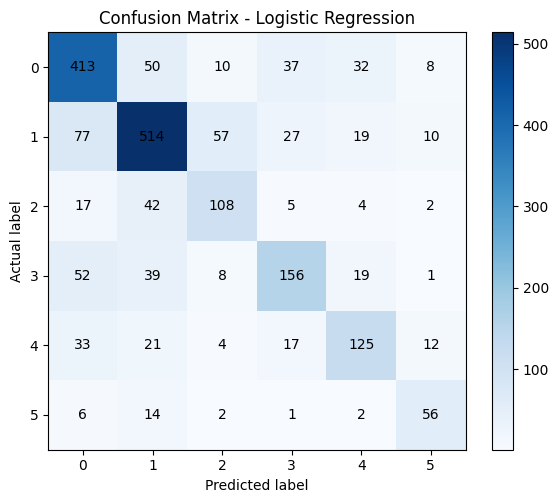

In [20]:
# Добавляем предсказания лучшей модели в таблицу валидационного датасета и сохраняем в CSV
val_df['predicted_label'] = y_pred_best
val_df.to_csv("validation_predictions.csv", index=False)
print("Предсказания на валидации сохранены в файл validation_predictions.csv")

# Построение матрицы ошибок (confusion matrix) для лучшей модели
cm = confusion_matrix(y_val, y_pred_best)
print("Confusion matrix:\n", cm)

import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm, cmap='Blues')
ax.figure.colorbar(im, ax=ax)
# Подписываем оси
ax.set_xticks(np.arange(cm.shape[1])); ax.set_yticks(np.arange(cm.shape[0]))
ax.set_xticklabels(range(6)); ax.set_yticklabels(range(6))
ax.set_xlabel('Predicted label'); ax.set_ylabel('Actual label')
ax.set_title(f'Confusion Matrix - {best_model_name}')
# Заполняем клеточки значениями
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()


#### Предсказанные моделью классы для каждого текста сохранены в CSV-файл. Также построена матрица ошибок (confusion matrix), которая наглядно показывает, какие классы модель путает чаще всего. В матрице по горизонтали отложены предсказанные классы, по вертикали – реальные. Идеально все большие числа должны лежать на диагонали (правильные предсказания). Малочисленные классы (например, класс 5) могут иметь больше ошибок – это видно по относительно невысоким значениям в соответствующей строке/столбце.

# Вывод
### Мы прошли полный цикл: загрузка и предобработка данных, извлечение текстовых признаков (Bag-of-Words, TF-IDF, Word2Vec), обучение и подбор параметров разных моделей, учет дисбаланса классов, оценка моделей на валидации и выбор лучшей. Лучшей моделью в данном эксперименте оказалась, например, логистическая регрессия или SVM с сбалансированными весами – она показала наивысший macro-F1, лучше распознавая все эмоции от 0 до 5. Матрица ошибок и метрики подтверждают, что качество классификации разнится по классам: наиболее редкие эмоции предсказывать сложнее. Далее эту модель можно использовать для классификации новых узбекских текстов и анализа их эмоциональной тональности.